In [1]:
import sys
import os
import struct
import time
import copy
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
%matplotlib inline

fpX = np.float32

import torch 
root = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.append(os.path.join(root, 'code'))
from plotting import plot_utils, plot_prf_params, summary_plots, load_fits
from utils import roi_utils
# plot_utils.set_plotting_defaults()

In [2]:
# Load results of the fitting procedure

subject = 1
volume_space=True
fitting_type = 'texture_pyramid_ridge_4ori_4sf_plus_sketch_tokens_stacked'

root = os.path.dirname(os.path.dirname(os.getcwd()))
out, fig_save_folder = load_fits.load_fit_results(subject, volume_space, fitting_type, n_from_end=0, root=root, verbose=False)
# print_output_summary(out)
roi_def = roi_utils.get_combined_rois(subject,include_all=False,include_body=False,volume_space=True,verbose=False) 
skip_inds = [10,11,15,23]

if not os.path.exists(fig_save_folder):
    os.makedirs(fig_save_folder)

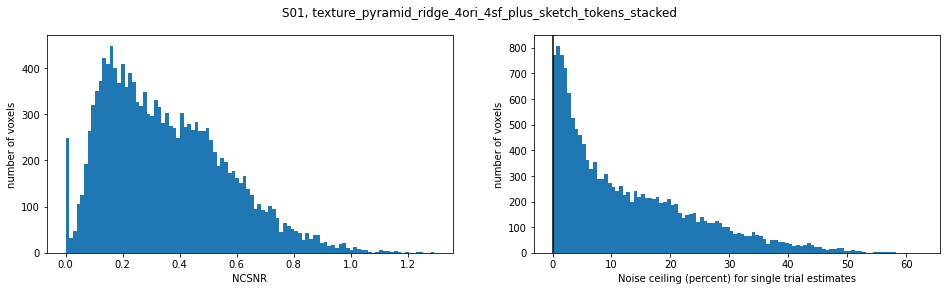

In [4]:
summary_plots.plot_noise_ceilings(subject, fitting_type,out, fig_save_folder)

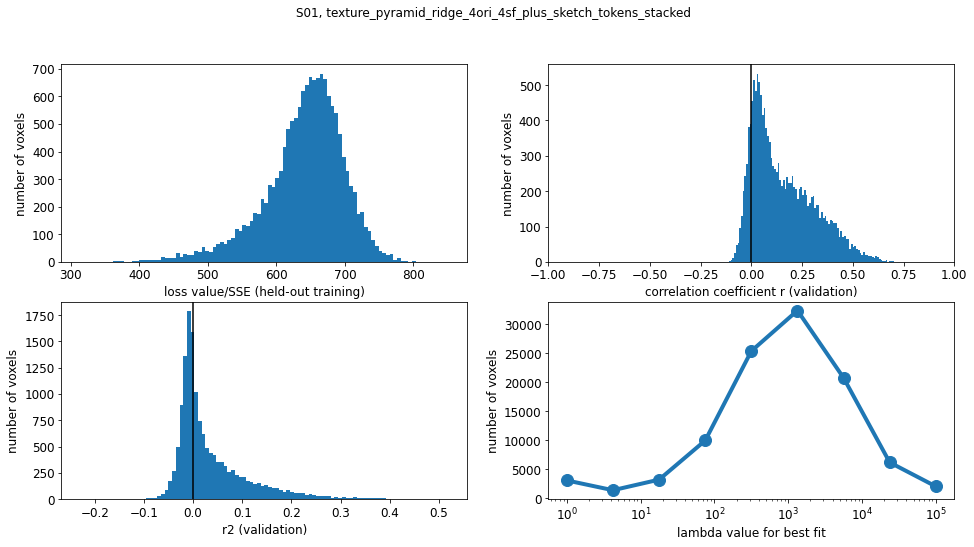

In [6]:
plot_utils.set_all_font_sizes(fs = 12)
summary_plots.plot_perf_summary(subject, fitting_type, out,fig_save_folder=None)

In [8]:
summary_plots.plot_summary_pycortex(subject, fitting_type, out, port=33333, roi_def=roi_def)

Data is in 3d volume space
navigate browser to: 127.0.0.1:33333
Started server on port 33333
Stopping server


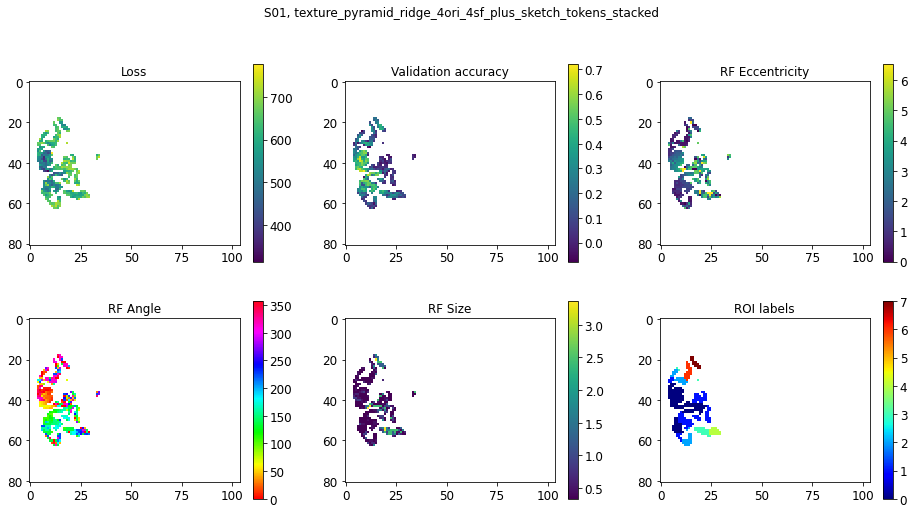

In [9]:
summary_plots.plot_fit_summary_volume_space(subject, fitting_type, out, roi_def, screen_eccen_deg = 8.4, fig_save_folder=None)
                              

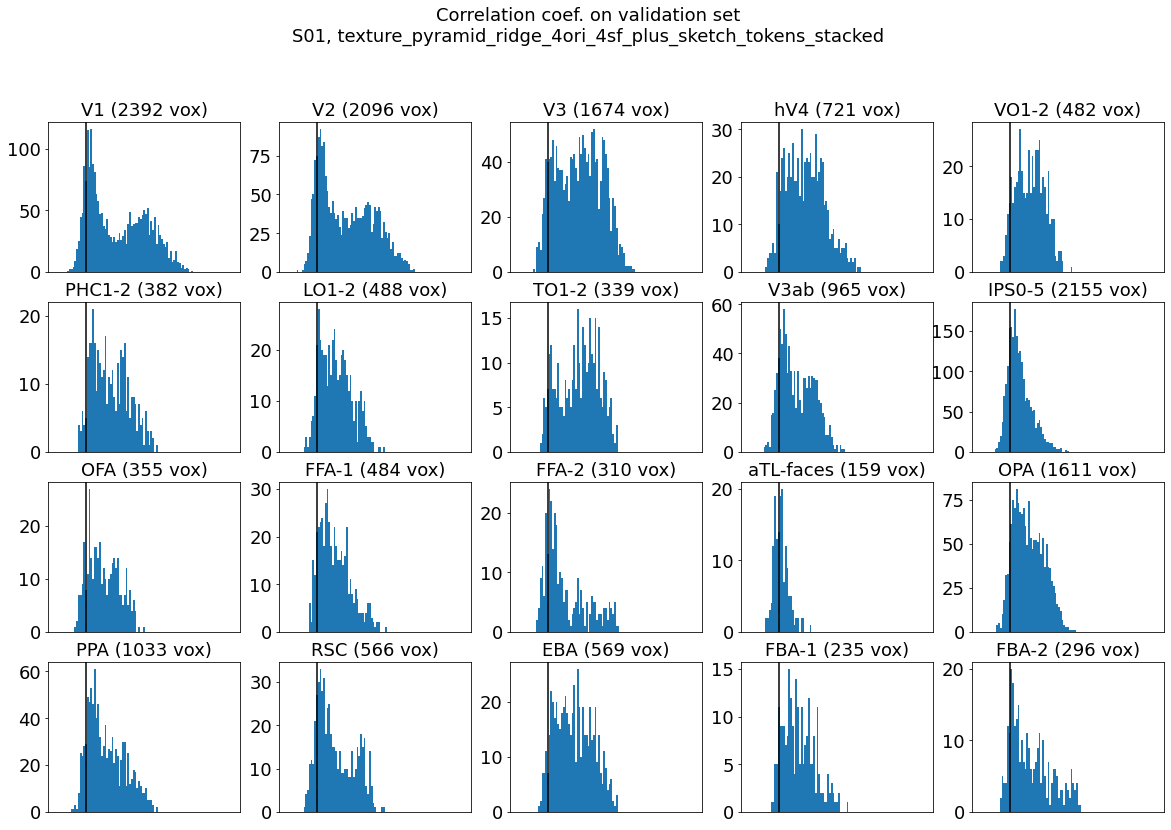

In [12]:
summary_plots.plot_cc_each_roi(subject, fitting_type,out, roi_def=roi_def, skip_inds=skip_inds, fig_save_folder=None)

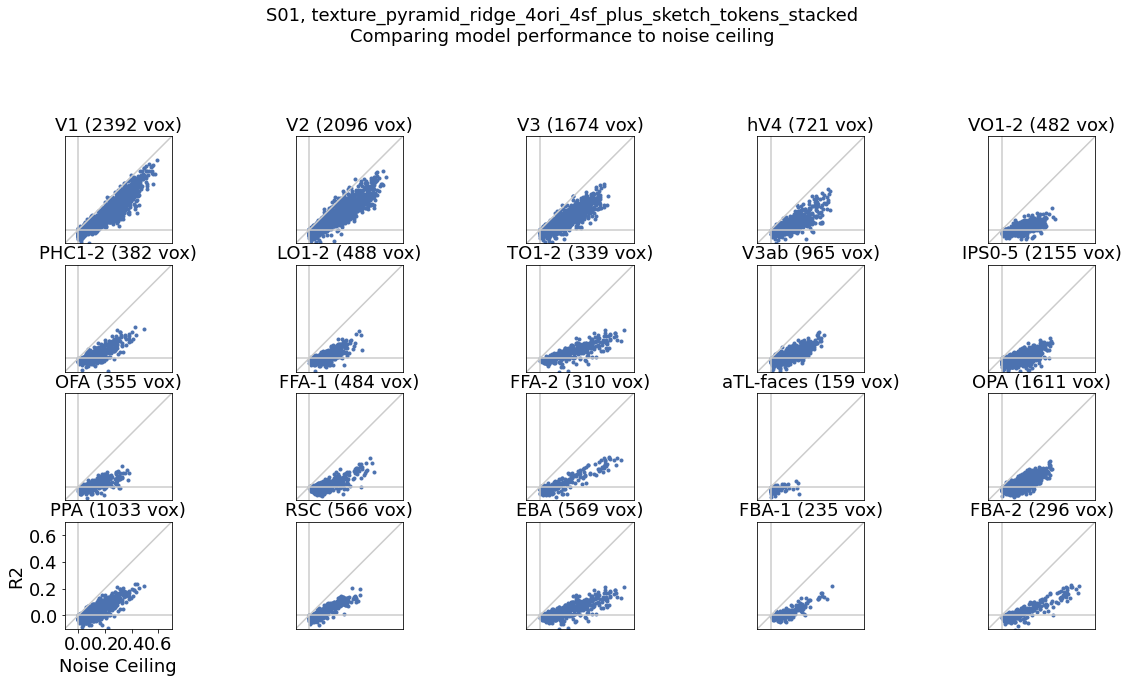

In [13]:
summary_plots.plot_r2_vs_nc(subject, fitting_type,out, roi_def=roi_def, skip_inds=skip_inds, fig_save_folder=None)

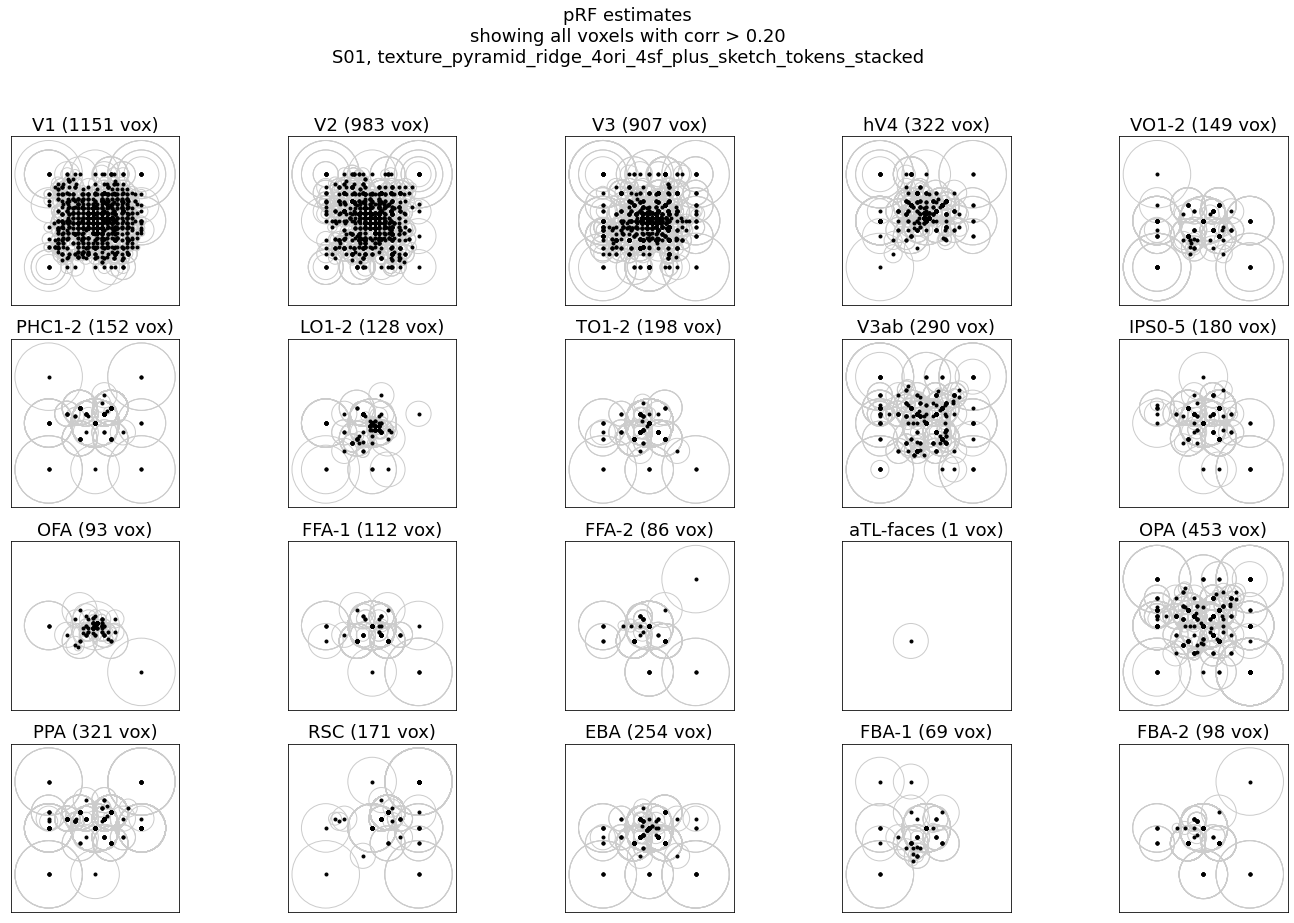

In [19]:
plot_prf_params.plot_spatial_rf_circles(subject, fitting_type, out, roi_def=roi_def, skip_inds=skip_inds, \
                                        cc_cutoff = 0.20, screen_eccen_deg = 8.4, fig_save_folder = None)

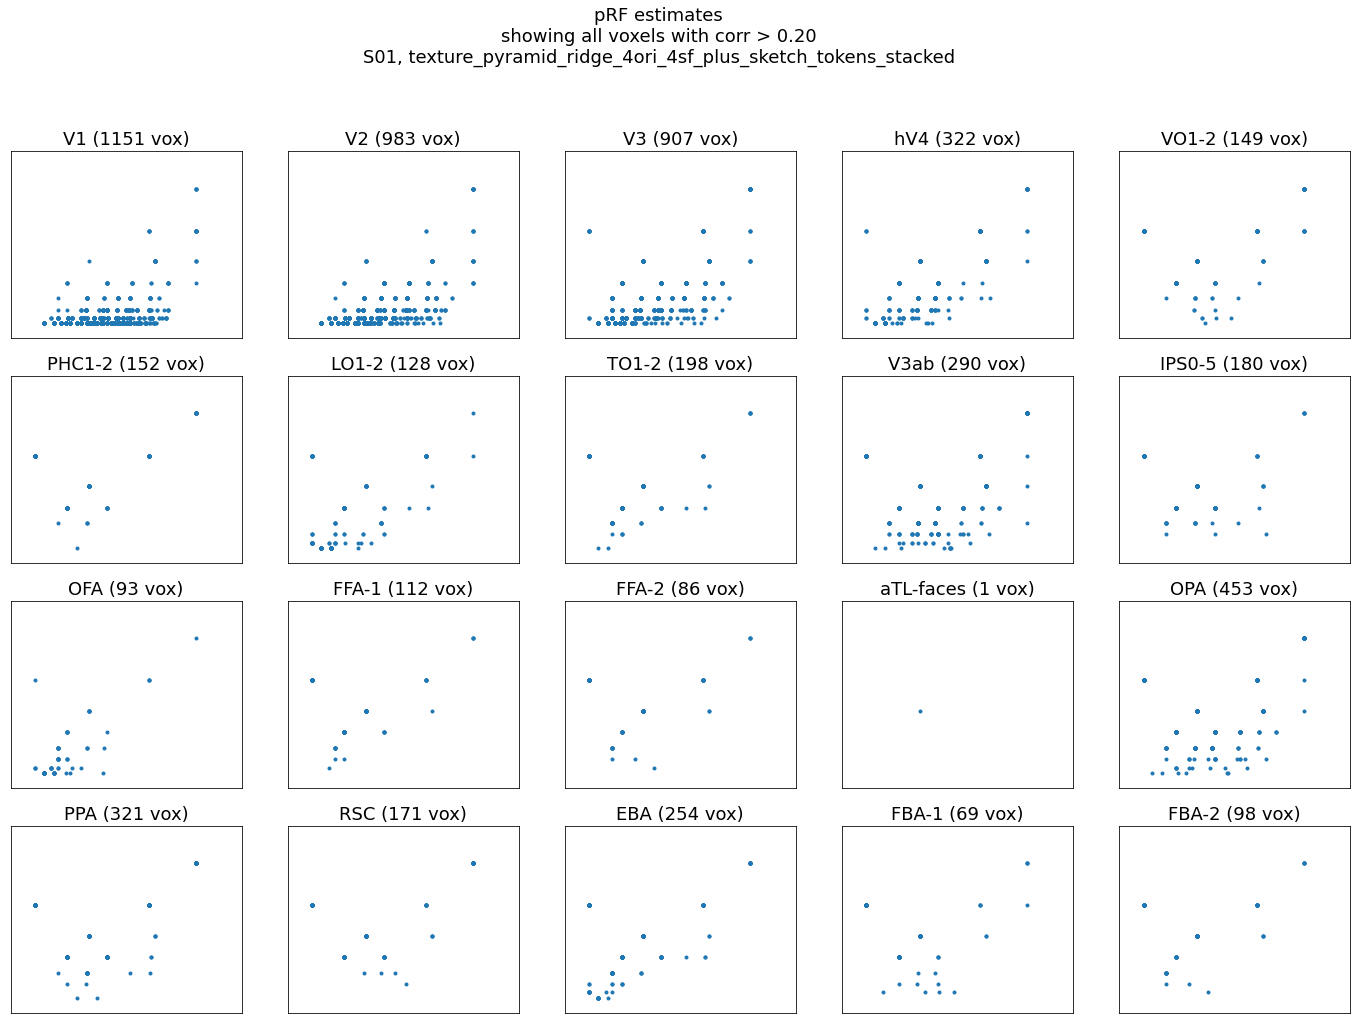

In [20]:
plot_prf_params.plot_size_vs_eccen(subject, fitting_type,out, roi_def=roi_def, skip_inds=skip_inds, \
                                   cc_cutoff=0.2, screen_eccen_deg = 8.4, fig_save_folder=None )

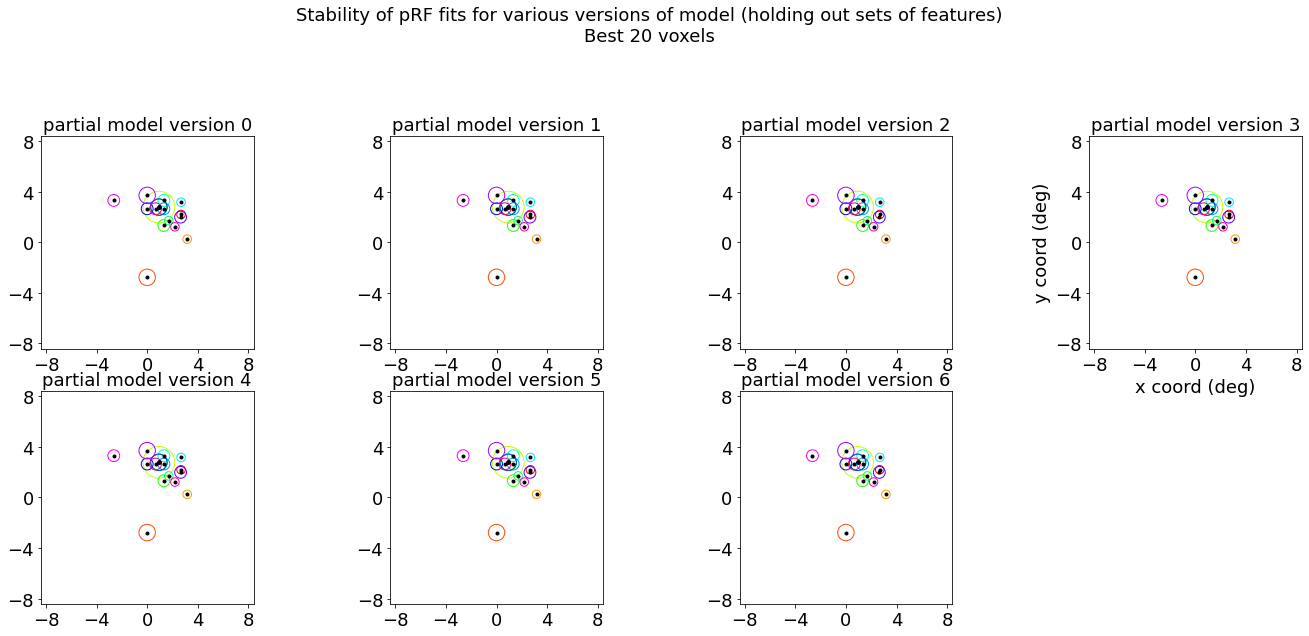

In [21]:
plot_prf_params.plot_prf_stability_partial_versions(subject, out, cc_cutoff = 0.2, \
                                                    screen_eccen_deg = 8.4, fig_save_folder = None)

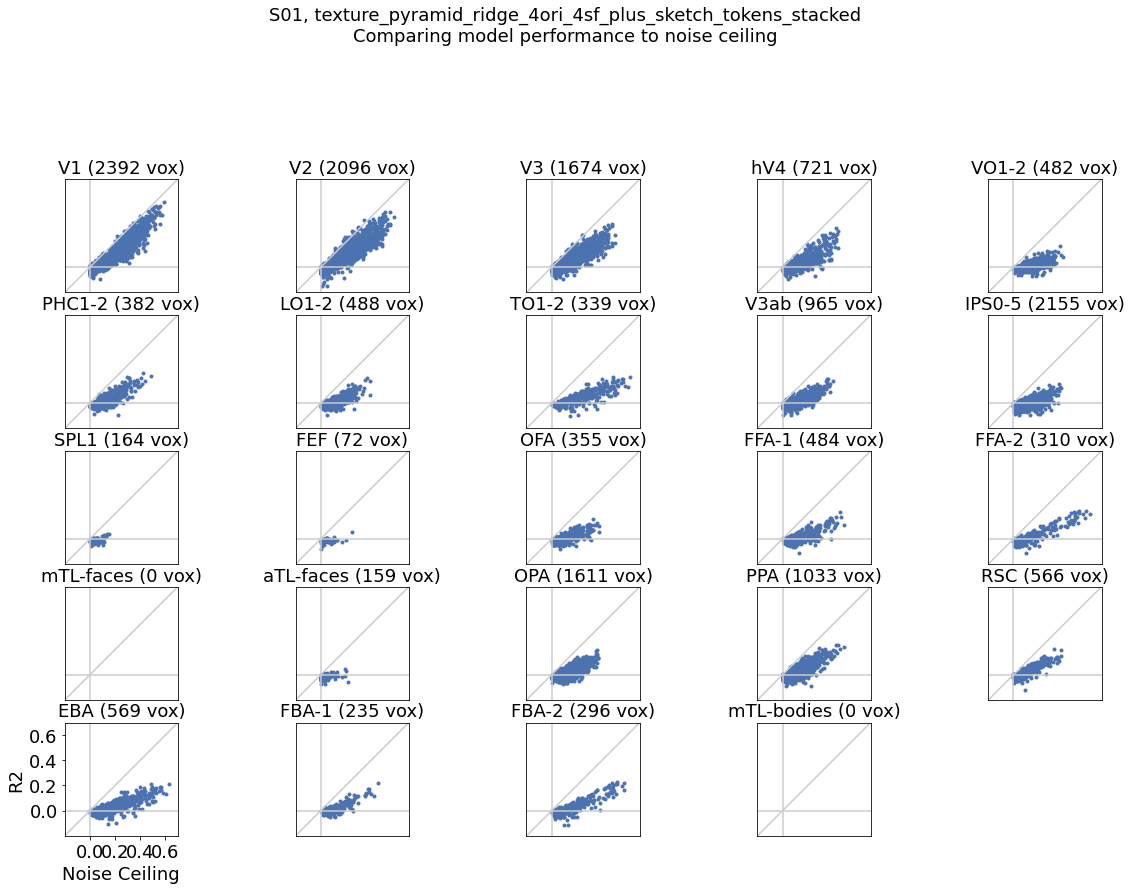

In [14]:
from utils import nsd_utils
plot_utils.set_all_font_sizes(fs = 18)
fig_size=(20,24)
voxel_ncsnr = out['voxel_ncsnr'].ravel()[out['voxel_index'][0]]
noise_ceiling = nsd_utils.ncsnr_to_nc(voxel_ncsnr)/100
# val_r2 = np.sign(out['val_cc'][:,0])*out['val_cc'][:,0]**2
val_r2 = out['val_r2'][:,0]
inds2use = np.ones(np.shape(val_r2))==1

sp = plot_utils.scatter_plot(color=None, xlabel='Noise Ceiling', ylabel='R2', xlims=[-0.2, 0.7], ylims=[-0.2, 0.7], \
                  xticks=[0, 0.2, 0.4, 0.6], yticks=[0, 0.2, 0.4, 0.6],\
                                                        show_diagonal=True, show_axes=True);

if fig_size is None:
    fig_size = (20,18)
plot_utils.create_roi_subplots(np.concatenate([noise_ceiling[:,np.newaxis],val_r2[:,np.newaxis]], axis=1), inds2use, sp, subject, out,\
                    suptitle='S%02d, %s\nComparing model performance to noise ceiling'%(subject, fitting_type), \
                   label_just_corner=True, figsize=fig_size, roi_def=roi_def)
plt.gcf().subplots_adjust(bottom=0.5)
if fig_save_folder is not None:
    plt.savefig(os.path.join(fig_save_folder,'r2_concat_vs_noiseceiling.png'))
    plt.savefig(os.path.join(fig_save_folder,'r2_concat_vs_noiseceiling.pdf'))



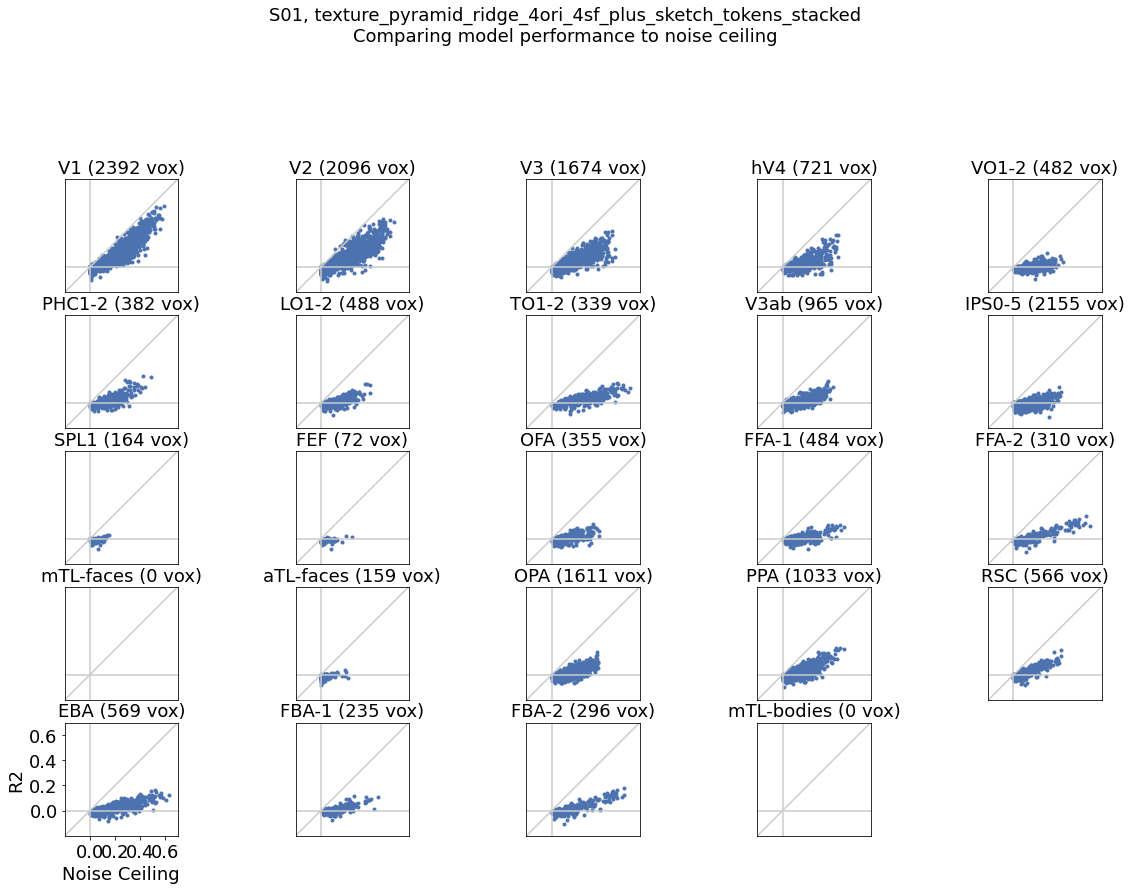

In [15]:
from utils import nsd_utils
plot_utils.set_all_font_sizes(fs = 18)
fig_size=(20,24)
voxel_ncsnr = out['voxel_ncsnr'].ravel()[out['voxel_index'][0]]
noise_ceiling = nsd_utils.ncsnr_to_nc(voxel_ncsnr)/100
# val_r2 = np.sign(out['val_cc'][:,1])*out['val_cc'][:,1]**2
val_r2 = out['val_r2'][:,1]
inds2use = np.ones(np.shape(val_r2))==1

sp = plot_utils.scatter_plot(color=None, xlabel='Noise Ceiling', ylabel='R2', xlims=[-0.2, 0.7], ylims=[-0.2, 0.7], \
                  xticks=[0, 0.2, 0.4, 0.6], yticks=[0, 0.2, 0.4, 0.6],\
                                                        show_diagonal=True, show_axes=True);

if fig_size is None:
    fig_size = (20,18)
plot_utils.create_roi_subplots(np.concatenate([noise_ceiling[:,np.newaxis],val_r2[:,np.newaxis]], axis=1), inds2use, sp, subject, out,\
                    suptitle='S%02d, %s\nComparing model performance to noise ceiling'%(subject, fitting_type), \
                   label_just_corner=True, figsize=fig_size, roi_def=roi_def)
plt.gcf().subplots_adjust(bottom=0.5)
if fig_save_folder is not None:
    plt.savefig(os.path.join(fig_save_folder,'r2_textureonly_vs_noiseceiling.png'))
    plt.savefig(os.path.join(fig_save_folder,'r2_textureonly_vs_noiseceiling.pdf'))



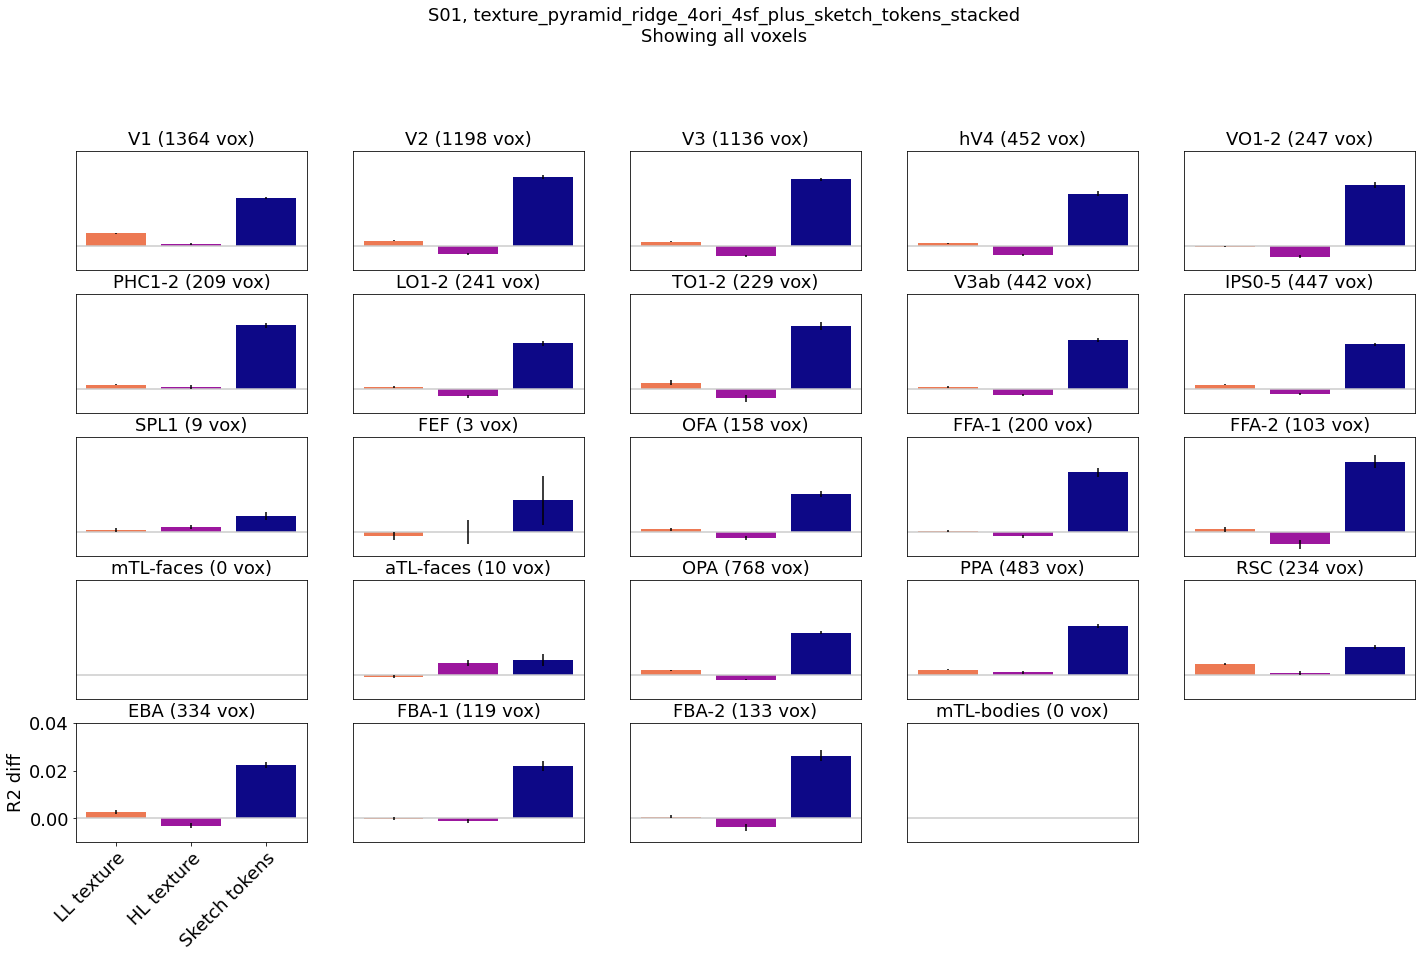

In [16]:
# Plotting unique variance explained by each feature set, using the concatenated model

plot_utils.set_all_font_sizes(fs = 18)

ve_names = ['LL texture', 'HL texture', 'Sketch tokens']

ppinds = [5, 4, 1]
r2 = out['val_r2']
# r2 = np.sign(out['val_cc'])*out['val_cc']**2
var_expl = r2[:,0:1] - r2[:,ppinds]


colors = cm.plasma(np.linspace(0,1,4))[0:-1]
colors = np.flipud(colors)
# colors = np.concatenate((np.array([[0.6, 0.6, 0.6, 1]]), colors[1:,:]), axis=0)

inds2use = r2[:,0]>0.01
# inds2use = np.ones(np.shape(var_expl)[0])==1

bp = plot_utils.bar_plot(colors=colors, column_labels=ve_names, ylabel='R2 diff', \
                                                        horizontal_line_pos=0, ylims = [-0.01, 0.04])
plot_utils.create_roi_subplots(var_expl, inds2use, bp, subject, out, \
                    suptitle='S%02d, %s\nShowing all voxels'%(subject, fitting_type),
                               roi_def=roi_def)

plt.gcf().subplots_adjust(bottom=0.4)
if fig_save_folder is not None:
    plt.savefig(os.path.join(fig_save_folder,'Varexpl_each_concat_bar_eachroi.pdf'))
    plt.savefig(os.path.join(fig_save_folder,'Varexpl_each_concat_bar_eachroi.png'))
    


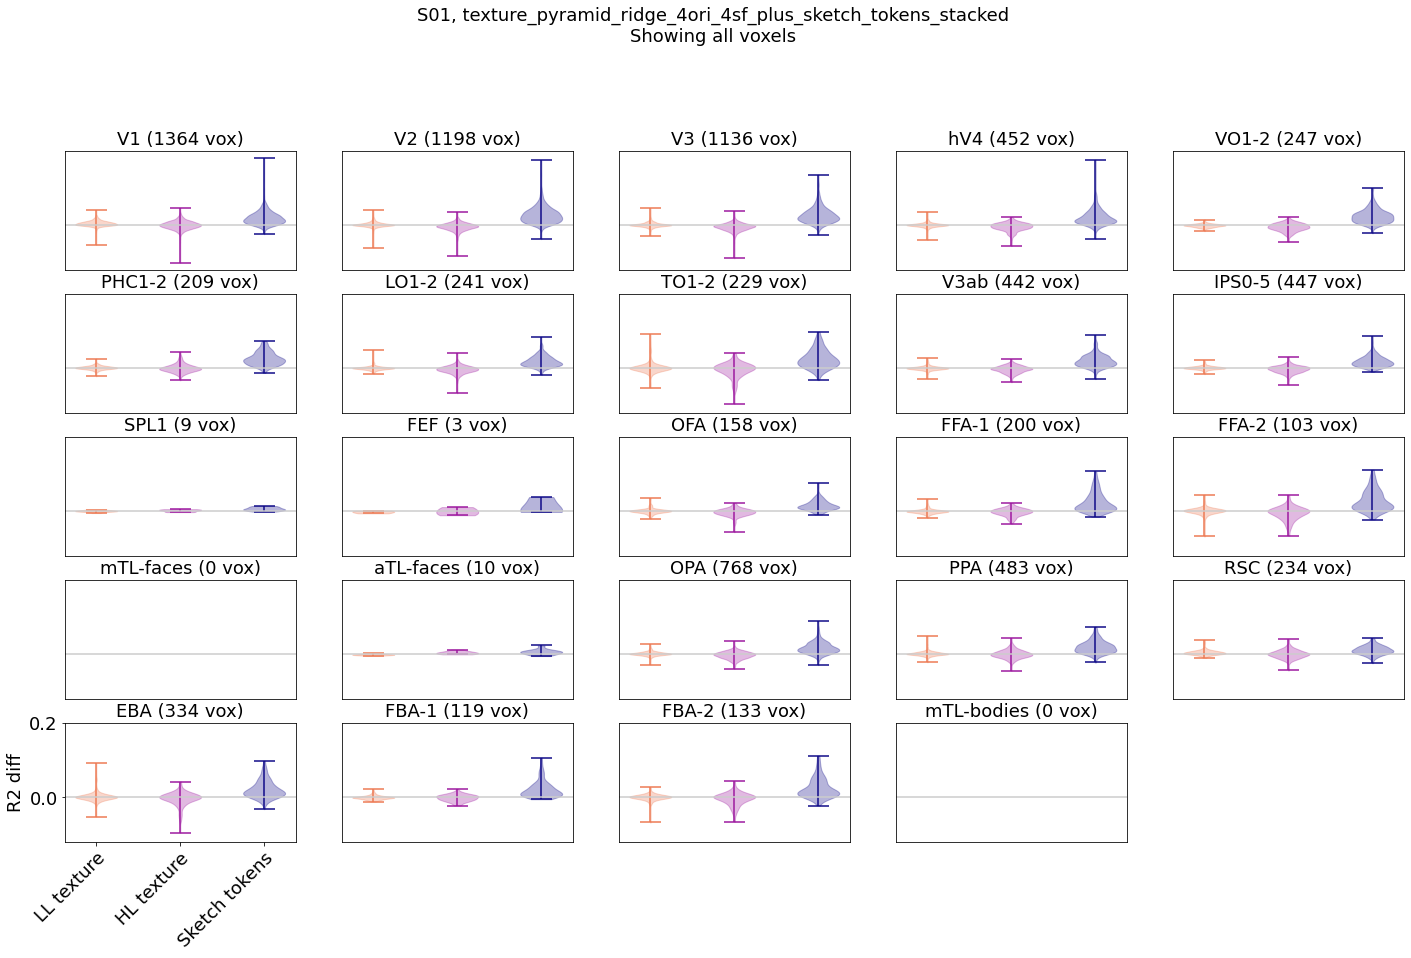

In [18]:
# Plotting unique variance explained by each feature set, using the concatenated model

# set_all_font_sizes(fs = 18)

ve_names = ['LL texture', 'HL texture', 'Sketch tokens']

ppinds = [5, 4, 1]
r2 = out['val_r2']
# bad_voxels = r2[:,0]<0
# r2 = np.sign(out['val_cc'])*out['val_cc']**2
var_expl = r2[:,0:1] - r2[:,ppinds]


colors = cm.plasma(np.linspace(0,1,4))[0:-1]
colors = np.flipud(colors)
# colors = np.concatenate((np.array([[0.6, 0.6, 0.6, 1]]), colors[1:,:]), axis=0)

# inds2use = np.ones(np.shape(var_expl)[0])==1
inds2use = r2[:,0]>0.01

vp = plot_utils.violin_plot(colors=colors, column_labels=ve_names, ylabel='R2 diff', \
                                                        horizontal_line_pos=0, ylims = [-0.12, 0.20])
plot_utils.create_roi_subplots(var_expl, inds2use, vp, subject, out, \
                    suptitle='S%02d, %s\nShowing all voxels'%(subject, fitting_type), \
                    roi_def=roi_def)

plt.gcf().subplots_adjust(bottom=0.4)
if fig_save_folder is not None:
    plt.savefig(os.path.join(fig_save_folder,'Varexpl_each_concat_violin_eachroi.pdf'))
    plt.savefig(os.path.join(fig_save_folder,'Varexpl_each_concat_violin_eachroi.png'))
    
